In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from matplotlib.pyplot import figure, show
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

Using TensorFlow backend.


In [0]:
TRAIN_PATH = "/content/drive/My Drive/Colab Notebooks/FER/train.csv"
TEST_PATH = "/content/drive/My Drive/Colab Notebooks/FER/test.csv"
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/FER/trained_model.h5"

In [4]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
print(train_df.describe)
print(test_df.describe)
print(train_df.shape)
print(test_df.shape)

<bound method NDFrame.describe of        emotion                                             pixels
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1            0  151 150 147 155 148 133 111 140 170 174 182 15...
2            2  231 212 156 164 174 138 161 173 182 200 106 38...
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...        ...                                                ...
28704        2  84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705        0  114 112 113 113 111 111 112 113 115 113 114 11...
28706        4  74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707        0  222 227 203 90 86 90 84 77 94 87 99 119 134 14...
28708        4  195 199 205 206 205 203 206 209 208 210 212 21...

[28709 rows x 2 columns]>
<bound method NDFrame.describe of                                                  pixels
0     254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1

In [0]:
EMOTIONS = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

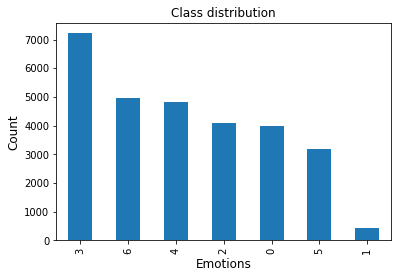

In [6]:
train_df['emotion'].value_counts().plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [7]:

enc_train = OneHotEncoder(handle_unknown='ignore')

train_labels = train_df['emotion'].to_numpy().reshape(-1,1)
enc_train.fit(train_labels)
train_labels = enc_train.transform(train_labels).toarray() 
n_samples = train_labels.shape[0]
train_image_data =  np.array([np.fromstring(sample, dtype=int, sep=' ').reshape(48,48,1) for sample in train_df['pixels'].to_numpy()]) 
train_image_data = train_image_data.astype(np.float32)/255.0


print(train_image_data.shape)
print(train_labels.shape)
print(n_samples)

#------------

test_n_samples = test_df.shape[0]
test_image_data =  np.array([np.fromstring(sample, dtype=int, sep=' ').reshape(48,48,1) for sample in test_df['pixels'].to_numpy()]) 

print(test_image_data.shape)
print(test_n_samples)

#-------------
train_datagen = ImageDataGenerator(
    rescale=1.0,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_datagen.fit(train_image_data)
#-----------------
test_datagen = ImageDataGenerator(rescale=1.0)
test_datagen.fit(test_image_data)

(28709, 48, 48, 1)
(28709, 7)
28709
(7178, 48, 48, 1)
7178


In [0]:
#building keras model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, ConvLSTM2D
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.layers.advanced_activations import ELU
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from keras import metrics

In [0]:

def baseline_model(drop_rate=0.1, regularization_val=0.0001):
  # Create the model
  model = Sequential()

  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu',
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same',
                   input_shape=(48,48,1)))

  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same',
                   input_shape=(48,48,1)))
  model.add(BatchNormalization())
  model.add(Dropout(drop_rate))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same') )
  # model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, kernel_size=(1, 1), activation='relu', 
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same'))
  # model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', 
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', 
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same'))
  # model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', 
  #                  kernel_regularizer=regularizers.l2(regularization_val)))
  # model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', 
  #                  kernel_regularizer=regularizers.l2(regularization_val)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))


  model.add(Conv2D(256, kernel_size=(1, 1), activation='relu',                    #changed 7 to 256
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same'))
  # model.add(BatchNormalization())

  model.add(MaxPooling2D(pool_size=(1, 1)))

  model.add(Conv2D(7, kernel_size=(4, 4), activation='relu',                      
                   kernel_regularizer=regularizers.l2(regularization_val), 
                   padding='same'))
  # model.add(BatchNormalization())

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(drop_rate))
  model.add(Dense(128, activation='relu'))  #new1
  model.add(Dropout(drop_rate))
  model.add(Dense(64, activation='relu'))  #new1
  model.add(Dropout(drop_rate))
  model.add(Dense(7, activation='relu'))

  model.add(Activation("softmax"))

  model.summary()
  metrics = ['categorical_accuracy']
  adam = Adam(lr = 1e-3)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=metrics)
  return model


In [10]:
model_ = baseline_model(drop_rate=0.2, regularization_val=0.00001)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0   

In [0]:

es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
# history = model_.fit(train_image_data, train_labels, validation_split=0.20, epochs=50, batch_size=64, verbose=1, callbacks=[es])
batch_size=64
def train_model():
  history = model_.fit_generator(
    train_datagen.flow(train_image_data,train_labels, batch_size=batch_size, subset='training'), 
    epochs=100, 
    steps_per_epoch=len(train_image_data) / batch_size, 
    verbose=1,
    validation_data=train_datagen.flow(train_image_data,train_labels, batch_size=batch_size, subset='validation'),
    callbacks=[es])
  return history

In [12]:
history = train_model()  

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
449/448 [==============================] - 24s 53ms/step - loss: 1.8655 - categorical_accuracy: 0.2580 - val_loss: 1.7501 - val_categorical_accuracy: 0.2878
Epoch 2/100
449/448 [==============================] - 15s 33ms/step - loss: 1.6963 - categorical_accuracy: 0.3138 - val_loss: 1.6229 - val_categorical_accuracy: 0.3376
Epoch 3/100
449/448 [==============================] - 15s 33ms/step - loss: 1.5692 - categorical_accuracy: 0.3731 - val_loss: 1.5138 - val_categorical_accuracy: 0.3799
Epoch 4/100
449/448 [==============================] - 15s 33ms/step - loss: 1.4929 - categorical_accuracy: 0.4064 - val_loss: 1.4552 - val_categorical_accuracy: 0.4196
Epoch 5/100
449/448 [==============================] - 15s 33ms/step - loss: 1.4537 - categorical_accuracy: 0.4293 - val_loss: 1.4331 - val_categorical_accuracy: 0.4370
Epoch 6/100
449/448 [==============================] - 15s 

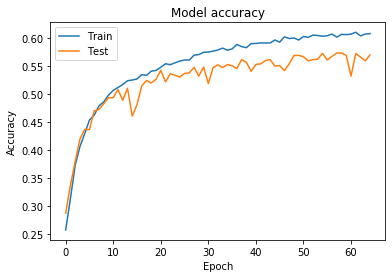

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

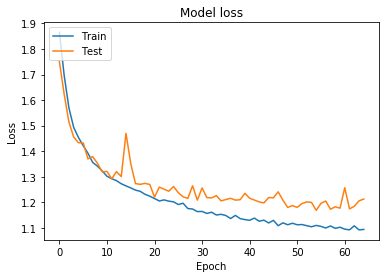

In [14]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
Y_pred = model_.predict_generator(test_datagen.flow(test_image_data), test_n_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

[6 3 3 ... 6 3 6]


In [0]:
model_.save(MODEL_PATH)